In [12]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from tensorflow import keras
import time
import matplotlib.pyplot as plt


Tarea 1A: DecisionStump y ADABoost Binario sin mejoras

In [2]:
import numpy as np

def balance_training_dataset(digit, X_train, y_train):
    # Find indices of the target digit and calculate how many there are
    target_indices = np.where(y_train == digit)[0]
    num_target_samples = len(target_indices)
    #print(f"Total elements for target digit {digit}: {num_target_samples}")

    # Determine how many samples each non-target digit should have
    num_samples_per_other_digit = num_target_samples // 9
    #print(f"Each non-target digit will have {num_samples_per_other_digit} samples.")

    # Initialize lists to collect balanced dataset samples
    X_train_balanced = []
    y_train_balanced = []

    # Add target digit samples to the balanced dataset
    X_train_balanced.extend(X_train[target_indices])
    y_train_balanced.extend(y_train[target_indices])

    # Collect samples for each non-target digit class to balance the dataset
    for i in range(10):  # There are 10 digit classes (0-9)
        if i == digit:
            continue  # Skip the target digit
        indices = np.where(y_train == i)[0]
        if len(indices) >= num_samples_per_other_digit:
            balanced_indices = np.random.choice(indices, num_samples_per_other_digit, replace=False)
        else:
            balanced_indices = np.random.choice(indices, num_samples_per_other_digit, replace=True)
        X_train_balanced.extend(X_train[balanced_indices])
        y_train_balanced.extend([i] * num_samples_per_other_digit)
        #print(f"Collected {len(balanced_indices)} samples for digit {i}.")

    # Convert lists to numpy arrays for training
    X_train_balanced = np.array(X_train_balanced)
    y_train_balanced = np.array(y_train_balanced)

    # Convert labels to binary (1 for the specified digit, -1 for all others)
    y_train_binary_balanced = np.where(y_train_balanced == digit, 1, -1)

    # Shuffle the balanced training set
    shuffle_indices = np.random.permutation(len(X_train_balanced))
    X_train_balanced = X_train_balanced[shuffle_indices]
    y_train_binary_balanced = y_train_binary_balanced[shuffle_indices]

    return X_train_balanced, y_train_binary_balanced

In [6]:

import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, img_shape): # Inicializamos la clase
        self.feature_index = (np.random.randint(0, img_shape[0]), np.random.randint(0, img_shape[1])) # Elegimos un índice de característica aleatorio en 2D
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.img_shape = img_shape # Inicializamos la forma de la imagen
        self.alpha = None # Inicializamos el alpha

    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index[0], self.feature_index[1]] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, img_rows, img_cols = X.shape # Obtenemos el número de muestras y el tamaño de la imagen
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump((img_rows, img_cols)) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index[0], clf.feature_index[1]]), max(X[:, clf.feature_index[0], clf.feature_index[1]])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_on_mnist
    if verboseParam:
        print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X_train, y_train) # Convertimos las etiquetas a binarias
    
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias

    adaboost = AdaBoost(T=T, A=A) # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_balanced, Y_train_binary_balanced, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    if verboseParam:
        print(f"Accuracy for digit {digit}: {accuracy:.4f}") # Mostramos la precisión

    return y_test_binary, np.sign(y_pred), accuracy # Devolvemos las etiquetas verdaderas, las predicciones, y la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    all_true_labels = [] # Inicializamos las etiquetas verdaderas
    all_pred_labels = [] # Inicializamos las predicciones
    accuracies = {} # Inicializamos las precisiones

    for digit in range(10): # Para cada dígito
        y_test_binary, y_pred, accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        all_true_labels.extend(y_test_binary) # Guardamos las etiquetas verdaderas
        all_pred_labels.extend(y_pred) # Guardamos las predicciones
        accuracies[digit] = accuracy # Guardamos la precisión

        if verboseParam: # Si verboseParam es True
            print(f"Confusion Matrix for digit {digit}:") # Mostramos la matriz de confusión para cada dígito
            print_confusion_matrix(y_test_binary, y_pred) # Mostramos la matriz de confusión para cada dígito

    if verboseParam: # Si verboseParam es True
        print("Overall Confusion Matrix:") # Mostramos la matriz de confusión general
        print_confusion_matrix(all_true_labels, all_pred_labels) # Mostramos la matriz de confusión general

    return accuracies # Devolvemos las precisiones


def print_confusion_matrix(true_labels, pred_labels): # Creamos la función para mostrar la matriz de confusión
    num_classes = 2 # Número de clases (1 y -1)
    matrix = np.zeros((num_classes, num_classes), dtype=int) # Inicializamos la matriz de confusión

    for t, p in zip(true_labels, pred_labels): # Para cada par de etiquetas verdaderas y predicciones
        matrix[int((t + 1) / 2), int((p + 1) / 2)] += 1 # Actualizamos la matriz de confusión

    print(matrix) # Imprimimos la matriz de confusión

In [7]:
accuracy = run_adaboost_on_mnist(digit=3, T=50, A=20, verboseParam=False)  # Ejecutamos AdaBoost

In [12]:
all_accuracies = run_adaboost_for_all_digits(T=50, A=50, verboseParam=False) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Accuracies for all digits:


Tarea 1B: Experimentación con los parámetros T y A del método AdaboostBinario.predict

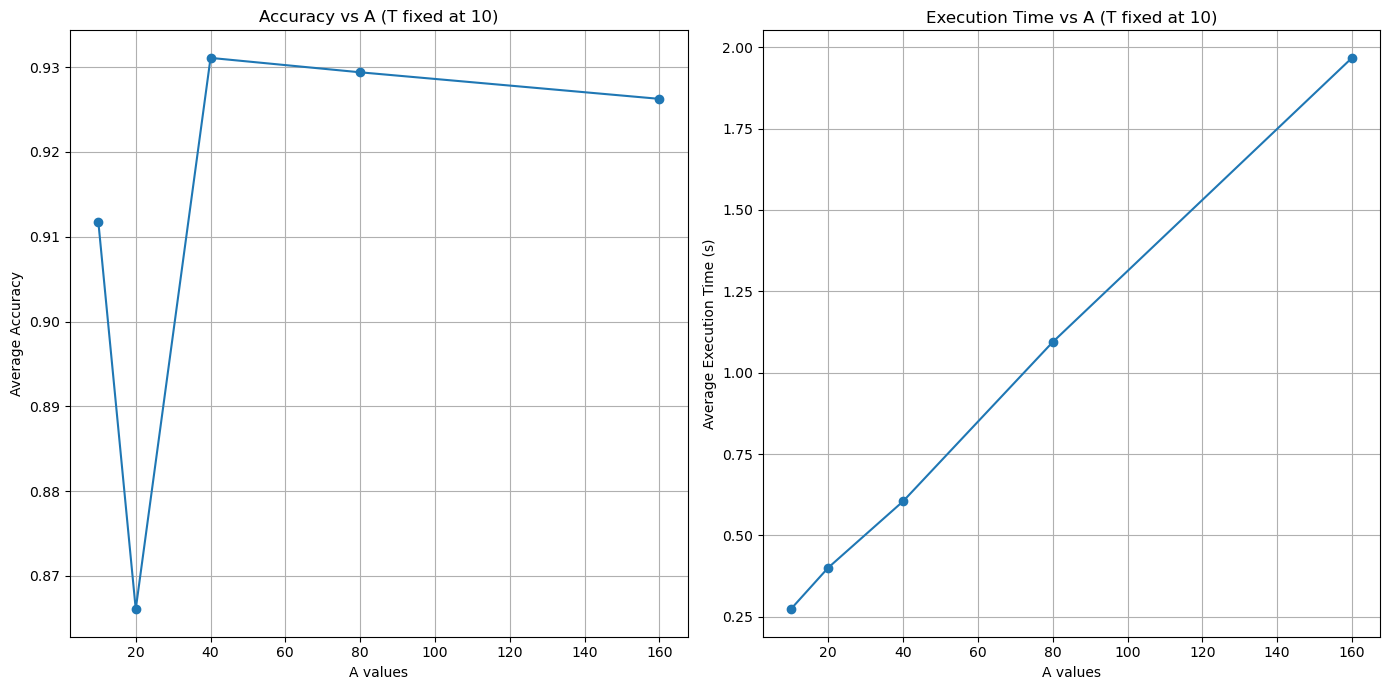

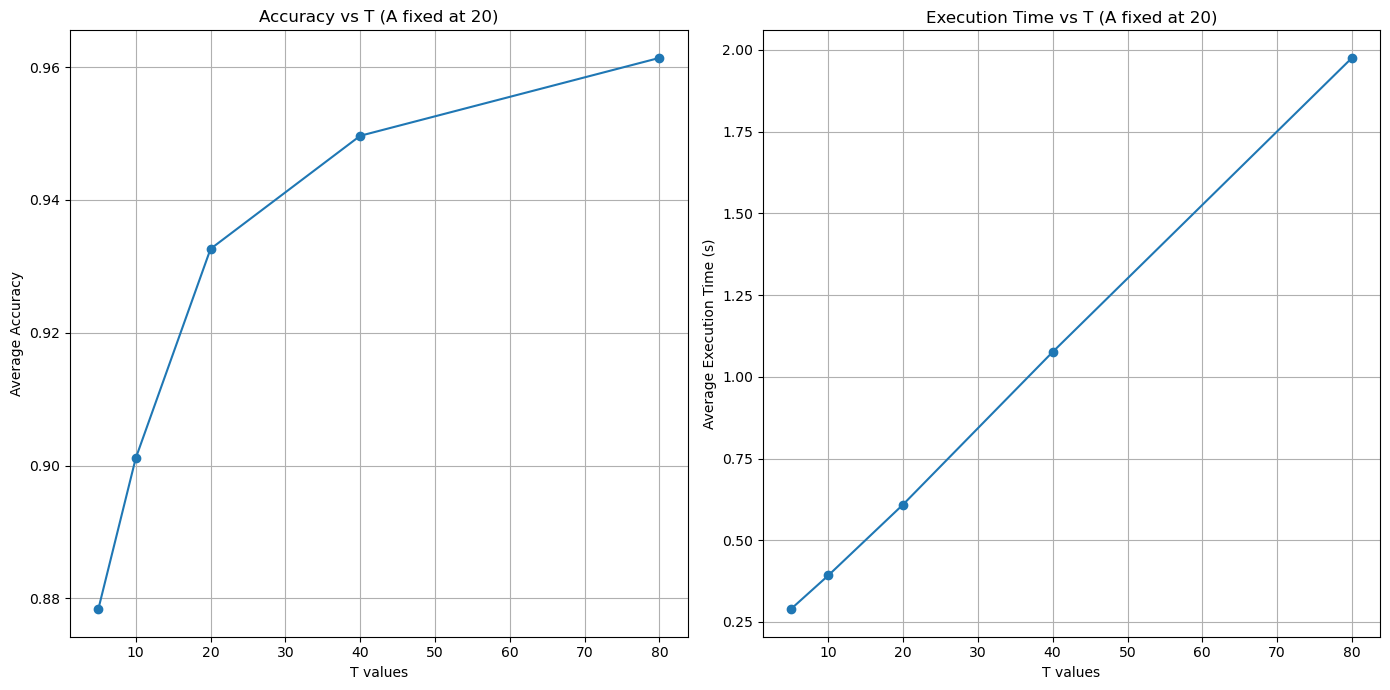

In [17]:
def experiment_adaboost_fixed_T(T_fixed, A_values, repetitions=3, verboseParam=False):
    accuracies = []
    execution_times = []

    for A in A_values:
        acc = []
        exec_time = []
        for _ in range(repetitions):
            start_time = time.time()
            y_test_binary, y_pred, accuracy = run_adaboost_on_mnist(digit=0, T=T_fixed, A=A, verboseParam=verboseParam)
            end_time = time.time()
            
            acc.append(accuracy)
            exec_time.append(end_time - start_time)

        avg_accuracy = np.mean(acc)
        avg_execution_time = np.mean(exec_time)
        accuracies.append(avg_accuracy)
        execution_times.append(avg_execution_time)

    # Plotting results
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(A_values, accuracies, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Accuracy')
    plt.title(f'Accuracy vs A (T fixed at {T_fixed})')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(A_values, execution_times, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Execution Time (s)')
    plt.title(f'Execution Time vs A (T fixed at {T_fixed})')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def experiment_adaboost_fixed_A(A_fixed, T_values, repetitions=3, verboseParam=False):
    accuracies = []
    execution_times = []

    for T in T_values:
        acc = []
        exec_time = []
        for _ in range(repetitions):
            start_time = time.time()
            y_test_binary, y_pred, accuracy = run_adaboost_on_mnist(digit=0, T=T, A=A_fixed, verboseParam=verboseParam)
            end_time = time.time()

            acc.append(accuracy)
            exec_time.append(end_time - start_time)

        avg_accuracy = np.mean(acc)
        avg_execution_time = np.mean(exec_time)
        accuracies.append(avg_accuracy)
        execution_times.append(avg_execution_time)

    # Plotting results
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(T_values, accuracies, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Accuracy')
    plt.title(f'Accuracy vs T (A fixed at {A_fixed})')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(T_values, execution_times, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Execution Time (s)')
    plt.title(f'Execution Time vs T (A fixed at {A_fixed})')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    T_fixed = 10
    A_values = [10, 20, 40, 80, 160]

    experiment_adaboost_fixed_T(T_fixed, A_values, repetitions=3, verboseParam=False)

    A_fixed = 20
    T_values = [5, 10, 20, 40, 80]

    experiment_adaboost_fixed_A(A_fixed, T_values, repetitions=3, verboseParam=False)


Tareas 1C: ADABoost Multiclase

In [13]:

import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, img_shape): # Inicializamos la clase
        self.feature_index = (np.random.randint(0, img_shape[0]), np.random.randint(0, img_shape[1])) # Elegimos un índice de característica aleatorio en 2D
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.img_shape = img_shape # Inicializamos la forma de la imagen
        self.alpha = None # Inicializamos el alpha

    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index[0], self.feature_index[1]] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, img_rows, img_cols = X.shape # Obtenemos el número de muestras y el tamaño de la imagen
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump((img_rows, img_cols)) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index[0], clf.feature_index[1]]), max(X[:, clf.feature_index[0], clf.feature_index[1]])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_on_mnist
    if verboseParam:
        print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X_train, y_train) # Convertimos las etiquetas a binarias
    
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias

    adaboost = AdaBoost(T=T, A=A) # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_balanced, Y_train_binary_balanced, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    if verboseParam:
        print(f"Accuracy for digit {digit}: {accuracy:.4f}") # Mostramos la precisión

    return y_test_binary, np.sign(y_pred), accuracy # Devolvemos las etiquetas verdaderas, las predicciones, y la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    all_true_labels = [] # Inicializamos las etiquetas verdaderas
    all_pred_labels = [] # Inicializamos las predicciones
    accuracies = {} # Inicializamos las precisiones

    for digit in range(10): # Para cada dígito
        y_test_binary, y_pred, accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        all_true_labels.extend(y_test_binary) # Guardamos las etiquetas verdaderas
        all_pred_labels.extend(y_pred) # Guardamos las predicciones
        accuracies[digit] = accuracy # Guardamos la precisión

        if verboseParam: # Si verboseParam es True
            print(f"Confusion Matrix for digit {digit}:") # Mostramos la matriz de confusión para cada dígito
            print_confusion_matrix(y_test_binary, y_pred) # Mostramos la matriz de confusión para cada dígito

    if verboseParam: # Si verboseParam es True
        print("Overall Confusion Matrix:") # Mostramos la matriz de confusión general
        print_confusion_matrix(all_true_labels, all_pred_labels) # Mostramos la matriz de confusión general

    return accuracies # Devolvemos las precisiones


def print_confusion_matrix(true_labels, pred_labels): # Creamos la función para mostrar la matriz de confusión
    num_classes = 2 # Número de clases (1 y -1)
    matrix = np.zeros((num_classes, num_classes), dtype=int) # Inicializamos la matriz de confusión

    for t, p in zip(true_labels, pred_labels): # Para cada par de etiquetas verdaderas y predicciones
        matrix[int((t + 1) / 2), int((p + 1) / 2)] += 1 # Actualizamos la matriz de confusión

    print(matrix) # Imprimimos la matriz de confusión

In [25]:
accuracy = run_adaboost_on_mnist(digit=3, T=5, A=20, verboseParam=True)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
Classifier 1/50: error = 0.33849918433931514, alpha = 0.3349947668702315
Classifier 2/50: error = 0.3106997162519273, alpha = 0.3984250491085186
Classifier 3/50: error = 0.38837506956392825, alpha = 0.22707384447524992
Classifier 4/50: error = 0.3429532850071525, alpha = 0.3250804383656356
Classifier 5/50: error = 0.412123499301554, alpha = 0.17759691646111855
Classifier 6/50: error = 0.3274360251371008, alpha = 0.3599022719009161
Classifier 7/50: error = 0.3887779466798608, alpha = 0.2262259848177318
Classifier 8/50: error = 0.40749030942754527, alpha = 0.18717503817160033
Classifier 9/50: error = 0.3844200954487763, alpha = 0.23541440224167226
Classifier 10/50: error = 0.4278677733121599, alpha = 0.14527796157705636
Classifier 11/50: error = 0.42888420627521323, alpha = 0.14320250654921057
Classifier 12/50: error = 0.36911958047175475, alpha = 0.267997838572084
Classifier 13/50: error = 0.4203585081576239, alpha = 0.16065092841057566
Classifier 14/50: er

In [31]:
all_accuracies = run_adaboost_for_all_digits(T=50, A=50, verboseParam=True) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Running AdaBoost for digit: 0
Classifier 1/50: error = 0.2035457999155762, alpha = 0.6821392926486513
Classifier 2/50: error = 0.2768742118876918, alpha = 0.4800099466272451
Classifier 3/50: error = 0.23922038011475588, alpha = 0.578479251623624
Classifier 4/50: error = 0.26593542153207284, alpha = 0.5076717514784609
Classifier 5/50: error = 0.2732654669052328, alpha = 0.4890587638711395
Classifier 6/50: error = 0.3471809030680289, alpha = 0.31572703918827366
Classifier 7/50: error = 0.31771068891563026, alpha = 0.382156296066432
Classifier 8/50: error = 0.37183289493489413, alpha = 0.2621808378227203
Classifier 9/50: error = 0.3487987955827282, alpha = 0.31216171254545655
Classifier 10/50: error = 0.3563222077036734, alpha = 0.2956814394596907
Classifier 11/50: error = 0.3814860067902861, alpha = 0.2416228226513782
Classifier 12/50: error = 0.3738594445359946, alpha = 0.25784748262776325
Classifier 13/50: error = 0.4481187911756851, alpha = 0.10413723276494292
Classifier 14/50: error 

In [14]:
class AdaBoostMulticlass: # Creamos la clase AdaBoostMulticlass
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.models = [] # Inicializamos los modelos

    def fit(self, X, y, verbose=False): # Creamos la función fit
        for digit in range(10): # Para cada dígito
            X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X, y)
            model = AdaBoost(T=self.T, A=self.A) # Creamos el clasificador AdaBoost
            model.fit(X_train_balanced, Y_train_binary_balanced, verbose) # Ajustamos el clasificador AdaBoost
            self.models.append(model) # Añadimos el clasificador AdaBoost

    def predict(self, X): # Creamos la función predict
        model_preds = np.array([model.predict(X) for model in self.models]) # Realizamos las predicciones
        return np.argmax(model_preds, axis=0) # Devolvemos el índice del valor máximo

def run_adaboost_multiclass_on_mnist(T=5, A=20, verboseParam=False,
                                     graph_param = False): # Creamos la función run_adaboost_multiclass_on_mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    adaboost_multiclass = AdaBoostMulticlass(T=T, A=A) # Creamos el clasificador AdaBoostMulticlass
    adaboost_multiclass.fit(X_train, y_train, verboseParam) # Ajustamos el clasificador AdaBoostMulticlass

    y_pred = np.zeros_like(y_test)
    for digit, model in enumerate(adaboost_multiclass.models):
        y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias
        model_pred = model.predict(X_test)
        y_pred[y_test == digit] = digit
        y_pred[y_test != digit] = np.argmax([model.predict(X_test) for model in adaboost_multiclass.models], axis=0)[y_test != digit]
        
        if verboseParam:
            print(f"Confusion Matrix for digit {digit}:")
            print_confusion_matrix(y_test_binary, np.sign(model_pred))

    accuracy = np.sum(y_test == y_pred) / len(y_test) # Calculamos la precisión
    if graph_param == False:
        print(f"Multiclass Accuracy: {accuracy}") # Mostramos la precisión
    return accuracy # Devolvemos la precisión



In [41]:
accuracy = run_adaboost_multiclass_on_mnist(T=50, A=20, verboseParam=False) # Ejecutamos AdaBoostMulticlass

Multiclass Accuracy: 0.8619


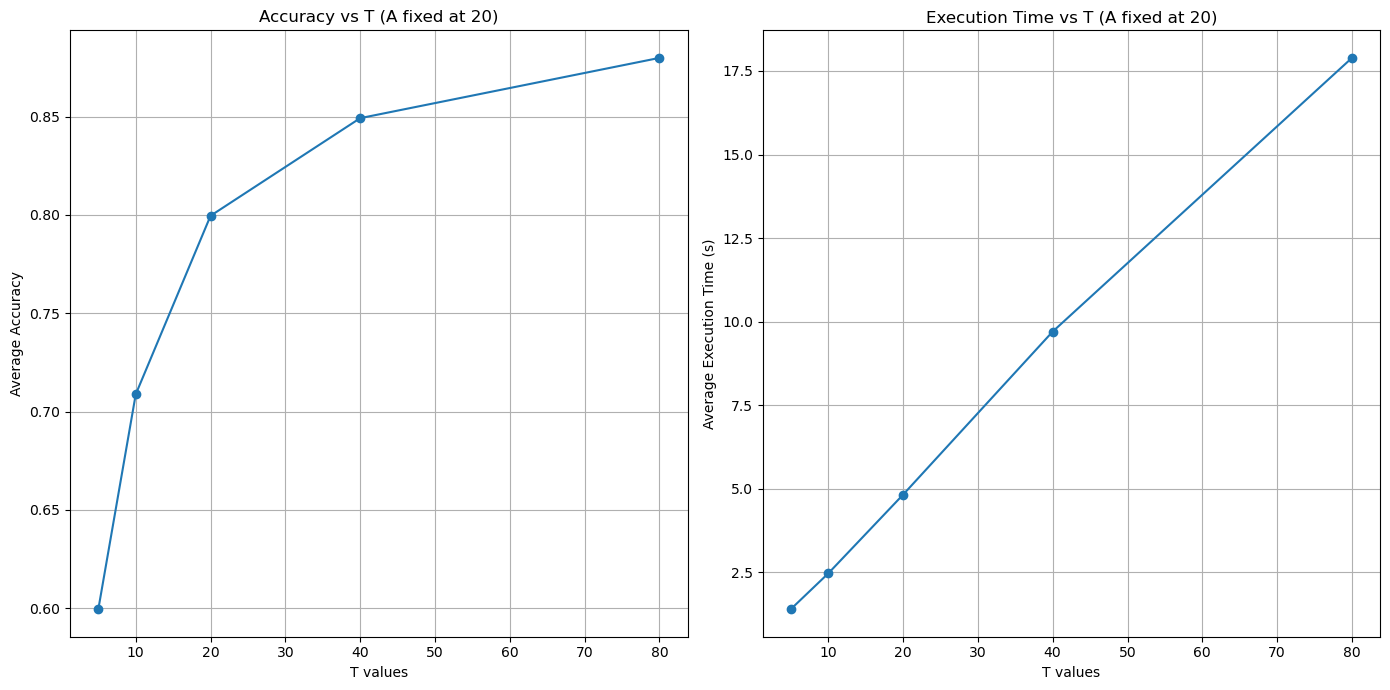

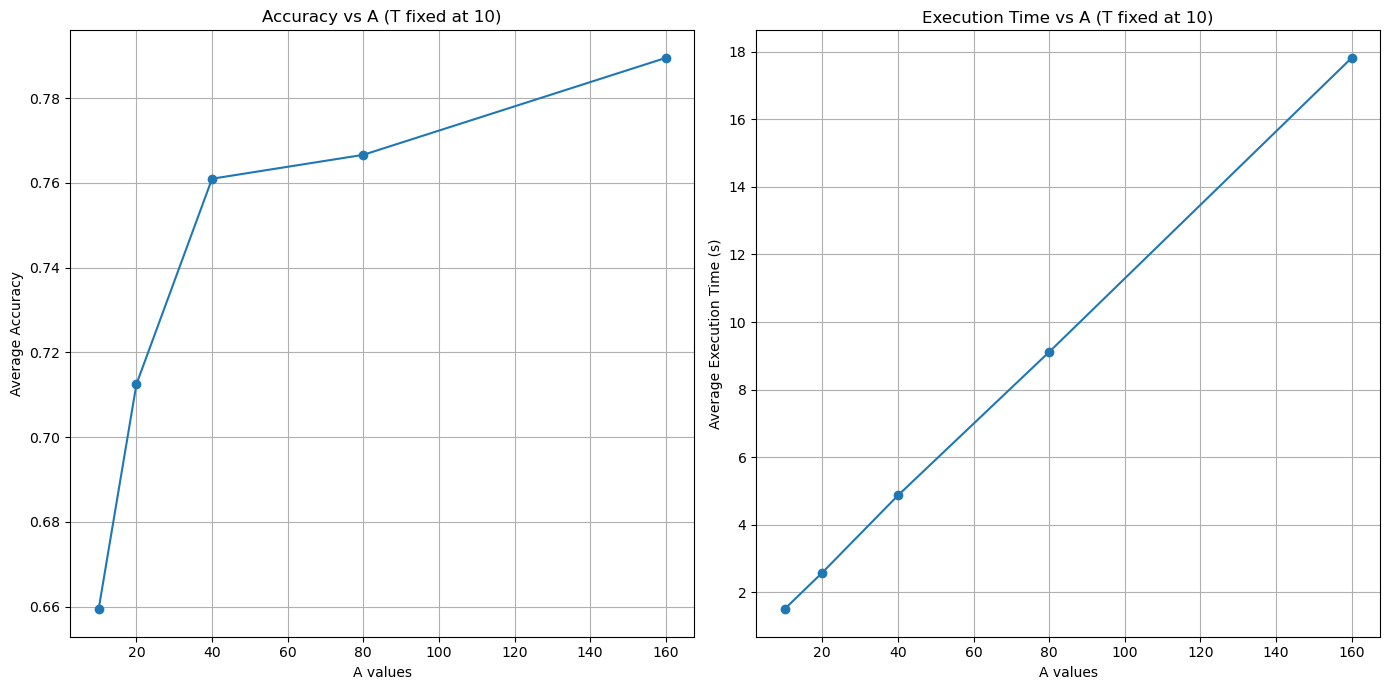

In [15]:
import matplotlib.pyplot as plt
import time
import numpy as np

def graph_experimentation_for_task_1C(number_of_reps):
    T_values = [5, 10, 20, 40, 80]
    A_values = [10, 20, 40, 80, 160]
    A_fixed = 20
    T_fixed = 10

    def run_experiment(T, A):
        acc = []
        exec_time = []
        for _ in range(number_of_reps):
            start_time = time.time()
            accuracy = run_adaboost_multiclass_on_mnist(T=T, A=A, verboseParam=False,
                                                        graph_param=True)
            end_time = time.time()
            acc.append(accuracy)
            exec_time.append(end_time - start_time)
        return np.mean(acc), np.mean(exec_time)

    # Accuracy vs T with A fixed
    accuracies_T = []
    exec_times_T = []
    for T in T_values:
        avg_acc, avg_exec_time = run_experiment(T, A_fixed)
        accuracies_T.append(avg_acc)
        exec_times_T.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(T_values, accuracies_T, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs T (A fixed at 20)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(T_values, exec_times_T, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs T (A fixed at 20)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Accuracy vs A with T fixed
    accuracies_A = []
    exec_times_A = []
    for A in A_values:
        avg_acc, avg_exec_time = run_experiment(T_fixed, A)
        accuracies_A.append(avg_acc)
        exec_times_A.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(A_values, accuracies_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs A (T fixed at 10)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(A_values, exec_times_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs A (T fixed at 10)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    number_of_reps = 3
    graph_experimentation_for_task_1C(number_of_reps)


TAREA 1D

Multiclase con ADABoosti Binario con Mejoras (Version 1: Solo añadido el parámetro n_componentes)

In [204]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST
from sklearn.decomposition import PCA # importamos Principal Component Analysis

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, n_features): # Inicializamos la clase
        self.feature_index = np.random.randint(0, n_features) # Elegimos un índice de característica aleatorio
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.n_features = n_features # Inicializamos el número de características
        self.alpha = None # Inicializamos el alpha
        
    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, n_features = X.shape # Obtenemos el número de muestras y el número de características
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump(n_features) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index]), max(X[:, clf.feature_index])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def apply_pca(X_train, X_test, n_components=50): # Creamos la función apply_pca
    pca = PCA(n_components=n_components) # Creamos el objeto PCA
    X_train_reduced = pca.fit_transform(X_train) # Aplicamos PCA a los datos de entrenamiento
    X_test_reduced = pca.transform(X_test) # Aplicamos PCA a los datos de prueba
    return X_train_reduced, X_test_reduced # Devolvemos los datos reducidos


def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False):
    print(f"Running AdaBoost for digit: {digit}")

    # Load MNIST data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Balance the training dataset for the specified digit
    X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X_train, y_train)

    # Flatten the images
    X_train_balanced = X_train_balanced.reshape(X_train_balanced.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Create the AdaBoost classifier (assuming AdaBoost class is properly defined and imported)
    adaboost = AdaBoost(T=T, A=A)
    adaboost.fit(X_train_balanced, Y_train_binary_balanced, verboseParam)  # Train the model
    y_pred = adaboost.predict(X_test)  # Predict on the test set

    # Convert test labels to binary
    y_test_binary = np.where(y_test == digit, 1, -1)

    # Calculate accuracy using the correct labels
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary)
    print(f"Accuracy for digit {digit}: {accuracy}")

    return accuracy


def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

In [205]:
accuracy = run_adaboost_on_mnist(digit=4, T=50, A=50, verboseParam=True)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 4
Total elements for target digit 4: 5842
Each non-target digit will have 649 samples.
Collected 649 samples for digit 0.
Collected 649 samples for digit 1.
Collected 649 samples for digit 2.
Collected 649 samples for digit 3.
Collected 649 samples for digit 5.
Collected 649 samples for digit 6.
Collected 649 samples for digit 7.
Collected 649 samples for digit 8.
Collected 649 samples for digit 9.
Classifier 1/50: error = 0.32654284002396616, alpha = 0.36193161781632127
Classifier 2/50: error = 0.3278824223679109, alpha = 0.35888910802399876
Classifier 3/50: error = 0.3102920104514464, alpha = 0.39937724049123485
Classifier 4/50: error = 0.34543031674796315, alpha = 0.31959355636828796
Classifier 5/50: error = 0.3359004284699686, alpha = 0.34080866150254474
Classifier 6/50: error = 0.3007772224580255, alpha = 0.42179976710006434
Classifier 7/50: error = 0.3291195840877196, alpha = 0.3560848705120504
Classifier 8/50: error = 0.37566007272679985, alpha = 0.25

In [206]:
all_accuracies = run_adaboost_for_all_digits(T=50, A=20, verboseParam=True) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Running AdaBoost for digit: 0
Total elements for target digit 0: 5923
Each non-target digit will have 658 samples.
Collected 658 samples for digit 1.
Collected 658 samples for digit 2.
Collected 658 samples for digit 3.
Collected 658 samples for digit 4.
Collected 658 samples for digit 5.
Collected 658 samples for digit 6.
Collected 658 samples for digit 7.
Collected 658 samples for digit 8.
Collected 658 samples for digit 9.
Classifier 1/50: error = 0.2584212747994935, alpha = 0.5270951122758907
Classifier 2/50: error = 0.2338948291435367, alpha = 0.5932239462830551
Classifier 3/50: error = 0.2530358589146863, alpha = 0.5412429831463339
Classifier 4/50: error = 0.24243996186387784, alpha = 0.5696743462229993
Classifier 5/50: error = 0.3391752783385592, alpha = 0.3334858070368075
Classifier 6/50: error = 0.2956139657450003, alpha = 0.4341360582070645
Classifier 7/50: error = 0.32158124068765226, alpha = 0.37325726590584635
Classifier 8/50: error = 0.438662777700055, alpha = 0.123295438

In [207]:
class AdaBoostMulticlass: # Creamos la clase AdaBoostMulticlass
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.models = [] # Inicializamos los modelos

    def fit(self, X, y, verbose=False): # Creamos la función fit
        for digit in range(10): # Para cada dígito
            X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X, y)
            model = AdaBoost(T=self.T, A=self.A) # Creamos el clasificador AdaBoost
            model.fit(X_train_balanced, Y_train_binary_balanced, verbose) # Ajustamos el clasificador AdaBoost
            self.models.append(model) # Añadimos el clasificador AdaBoost

    def predict(self, X): # Creamos la función predict
        model_preds = np.array([model.predict(X) for model in self.models]) # Realizamos las predicciones
        return np.argmax(model_preds, axis=0) # Devolvemos el índice del valor máximo

def run_adaboost_multiclass_on_mnist(T=5, A=20, verboseParam=False, n_components=50): # Creamos la función run_adaboost_multiclass_on_mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos
    X_train = X_train.reshape(X_train.shape[0], -1) # Redimensionamos los datos
    X_test = X_test.reshape(X_test.shape[0], -1) # Redimensionamos los datos

    # Apply PCA
    X_train_reduced, X_test_reduced = apply_pca(X_train, X_test, n_components=n_components)

    adaboost_multiclass = AdaBoostMulticlass(T=T, A=A) # Creamos el clasificador AdaBoostMulticlass
    adaboost_multiclass.fit(X_train_reduced, y_train, verboseParam) # Ajustamos el clasificador AdaBoostMulticlass
    y_pred = adaboost_multiclass.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test == y_pred) / len(y_test) # Calculamos la precisión
    print(f"Multiclass Accuracy: {accuracy}") # Mostramos la precisión
    return accuracy # Devolvemos la precisión


accuracy = run_adaboost_multiclass_on_mnist(T=50, A=20, verboseParam=True) # Ejecutamos AdaBoostMulticlass

Total elements for target digit 0: 5923
Each non-target digit will have 658 samples.
Collected 658 samples for digit 1.
Collected 658 samples for digit 2.
Collected 658 samples for digit 3.
Collected 658 samples for digit 4.
Collected 658 samples for digit 5.
Collected 658 samples for digit 6.
Collected 658 samples for digit 7.
Collected 658 samples for digit 8.
Collected 658 samples for digit 9.
Classifier 1/50: error = 0.4041367665681721, alpha = 0.19412890738154484
Classifier 2/50: error = 0.3923853820853689, alpha = 0.21864817719050703
Classifier 3/50: error = 0.3316592696588827, alpha = 0.3503449864978734
Classifier 4/50: error = 0.42129669262611685, alpha = 0.15872630256212605
Classifier 5/50: error = 0.4676664848826072, alpha = 0.06475739913816118
Classifier 6/50: error = 0.3009617329307832, alpha = 0.4213611812245938
Classifier 7/50: error = 0.339161624307877, alpha = 0.33351626666949763
Classifier 8/50: error = 0.1565972245519484, alpha = 0.8418837856699998
Classifier 9/50: er

Multiclase con ADABoosti Binario con Mejoras (Version 1: Añadidos los parámetros n_componentes y k)

In [138]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, n_features): # Inicializamos la clase
        self.feature_index = np.random.randint(0, n_features) # Elegimos un índice de característica aleatorio
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.n_features = n_features # Inicializamos el número de características
        self.alpha = None # Inicializamos el alpha
        
    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, n_features = X.shape # Obtenemos el número de muestras y el número de características
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump(n_features) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index]), max(X[:, clf.feature_index])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def apply_pca(X_train, X_test, n_components=50): # Creamos la función apply_pca
    pca = PCA(n_components=n_components) # Creamos el objeto PCA
    X_train_reduced = pca.fit_transform(X_train) # Aplicamos PCA a los datos de entrenamiento
    X_test_reduced = pca.transform(X_test) # Aplicamos PCA a los datos de prueba
    return X_train_reduced, X_test_reduced # Devolvemos los datos reducidos

def select_best_features(X_train, y_train, X_test, k=200): # Creamos la función select_best_features
    selector = SelectKBest(f_classif, k=k) # Creamos el objeto SelectKBest
    X_train_best = selector.fit_transform(X_train, y_train) # Seleccionamos las mejores características de los datos de entrenamiento
    X_test_best = selector.transform(X_test) # Seleccionamos las mejores características de los datos de prueba
    return X_train_best, X_test_best # Devolvemos los datos con las mejores características


def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False, n_components=50, k=200): # Creamos la función run_adaboost_on_mnist
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1) # Redimensionamos los datos para reducir la dimensión de las imagénes a 1D
    X_test = X_test.reshape(X_test.shape[0], -1) # Redimensionamos los datos para reducir la dimensión de las imagénes a 1D

    X_train_best, X_test_best = select_best_features(X_train, y_train, X_test, k=k) # Seleccionamos las mejores características


    X_train_reduced, X_test_reduced = apply_pca(X_train_best, X_test_best, n_components=n_components) # Aplicamos PCA a los datos

    y_train_binary = np.where(y_train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias

    adaboost = AdaBoost(T=T, A=A) # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_reduced, y_train_binary, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

In [88]:
accuracy = run_adaboost_on_mnist(digit=3, T=5, A=20, verboseParam=True)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
Classifier 1/5: error = 0.09578333333333311, alpha = 1.1224901549858723
Classifier 2/5: error = 0.423811546699126, alpha = 0.15357294594849832
Classifier 3/5: error = 0.44594286075021583, alpha = 0.10853849596112296
Classifier 4/5: error = 0.43261482746443425, alpha = 0.13559530076075985
Classifier 5/5: error = 0.47357464282143635, alpha = 0.05290000448255655
Accuracy for digit 3: 0.9003


In [89]:
all_accuracies = run_adaboost_for_all_digits(T=5, A=20, verboseParam=True) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Running AdaBoost for digit: 0
Classifier 1/5: error = 0.06493333333333336, alpha = 1.3336283620106117
Classifier 2/5: error = 0.40729086733956765, alpha = 0.18758809260424628
Classifier 3/5: error = 0.45367364809500965, alpha = 0.09291920425006518
Classifier 4/5: error = 0.36758716202838615, alpha = 0.2712909696472824
Classifier 5/5: error = 0.45306292554869954, alpha = 0.09415136693421174
Accuracy for digit 0: 0.934
Running AdaBoost for digit: 1
Classifier 1/5: error = 0.11243333333333305, alpha = 1.033061590861527
Classifier 2/5: error = 0.4453157110817808, alpha = 0.10980780466445449
Classifier 3/5: error = 0.1714455120615499, alpha = 0.7877085495093323
Classifier 4/5: error = 0.2813040656471276, alpha = 0.46900109941991674
Classifier 5/5: error = 0.4102413735063475, alpha = 0.18148382156901965
Accuracy for digit 1: 0.8865
Running AdaBoost for digit: 2
Classifier 1/5: error = 0.09931666666666639, alpha = 1.1024201675356724
Classifier 2/5: error = 0.40659765491248473, alpha = 0.18902

In [139]:
class AdaBoostMulticlass: # Creamos la clase AdaBoostMulticlass
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A# Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.models = [] # Inicializamos los modelos

    def fit(self, X, y, verbose=False): # Creamos la función fit
        for digit in range(10): # Para cada dígito
            y_binary = np.where(y == digit, 1, -1) # Convertimos las etiquetas a binarias
            model = AdaBoost(T=self.T, A=self.A) # Creamos el clasificador AdaBoost
            model.fit(X, y_binary, verbose) # Ajustamos el clasificador AdaBoost
            self.models.append(model) # Añadimos el clasificador AdaBoost

    def predict(self, X): # Creamos la función predict
        model_preds = np.array([model.predict(X) for model in self.models]) # Realizamos las predicciones
        return np.argmax(model_preds, axis=0) # Devolvemos el índice del valor máximo

def run_adaboost_multiclass_on_mnist(T=5, A=20, verboseParam=False, n_components=50, k=200): # Creamos la función run_adaboost_multiclass_on_mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos
    X_train = X_train.reshape(X_train.shape[0], -1) # Redimensionamos los datos
    X_test = X_test.reshape(X_test.shape[0], -1) # Redimensionamos los datos

    X_train_best, X_test_best = select_best_features(X_train, y_train, X_test, k=k) # Seleccionamos las mejores características

    X_train_reduced, X_test_reduced = apply_pca(X_train_best, X_test_best, n_components=n_components) # Aplicamos PCA a los datos

    adaboost_multiclass = AdaBoostMulticlass(T=T, A=A) # Creamos el clasificador AdaBoostMulticlass
    adaboost_multiclass.fit(X_train_reduced, y_train, verboseParam) # Ajustamos el clasificador AdaBoostMulticlass
    y_pred = adaboost_multiclass.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test == y_pred) / len(y_test) # Calculamos la precisión
    print(f"Multiclass Accuracy: {accuracy}") # Mostramos la precisión
    return accuracy # Devolvemos la precisión


accuracy = run_adaboost_multiclass_on_mnist(T=50, A=20, verboseParam=False) # Ejecutamos AdaBoostMulticlass

c:\Users\Crislt\anaconda3\envs\SIPrac2Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  0   1   2   3   4   5   6   7   8   9  10  11  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  52  53  54  55  56  57  82  83
  84  85 111 112 140 141 168 476 560 644 645 671 672 673 699 700 701 727
 728 729 730 754 755 756 757 758 759 780 781 782 783] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Crislt\anaconda3\envs\SIPrac2Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Multiclass Accuracy: 0.8016


Tarea 1E: Implementación de una versión de AdaboostBinario.fit que pare automáticamente el entrenamiento 
cuando detecte sobreentrenamiento.

In [208]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST
from sklearn.decomposition import PCA # importamos Principal Component Analysis

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, n_features): # Inicializamos la clase
        self.feature_index = np.random.randint(0, n_features) # Elegimos un índice de característica aleatorio
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.n_features = n_features # Inicializamos el número de características
        self.alpha = None # Inicializamos el alpha
        
    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, n_features = X.shape # Obtenemos el número de muestras y el número de características
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada clasificador débil
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada pixel
                clf = DecisionStump(n_features) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index]), max(X[:, clf.feature_index])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones
    
    def compute_optimal_number_of_weak_classificators(self, X_verification, y_verification, X_test, y_test, 
                                                      iterNumber = 100, numberOfTries = 10):
        bestAccuracy = 0
        newAccuracy = 0
        optimalNumberOfWeakClassificators = 5
        
        while round(newAccuracy, 6) >= round(bestAccuracy, 6):
            optimalNumberOfWeakClassificators += 1
            bestAccuracy = newAccuracy
            newAccuracy = 0
            for i in range(iterNumber):
                adaboost = AdaBoost(T=optimalNumberOfWeakClassificators, A=numberOfTries)
                adaboost.fit(X_verification, y_verification)
                y_pred = adaboost.predict(X_test)
                partialAccuracy = np.sum(y_test == np.sign(y_pred)) / len(y_test)
                newAccuracy += partialAccuracy
            newAccuracy /= iterNumber
        self.T = optimalNumberOfWeakClassificators
        #return optimalNumberOfWeakClassificators

    
def apply_pca(X_train, X_test, n_components=50): # Creamos la función apply_pca
    pca = PCA(n_components=n_components) # Creamos el objeto PCA
    X_train_reduced = pca.fit_transform(X_train) # Aplicamos PCA a los datos de entrenamiento
    X_test_reduced = pca.transform(X_test) # Aplicamos PCA a los datos de prueba
    return X_train_reduced, X_test_reduced # Devolvemos los datos reducidos


def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False, n_components=50): # Creamos la función run_adaboost_on_mnist
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1) # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1) # Aplanamos los datos de prueba reduciendo la dimensión a 1D   


    X_train_reduced, X_test_reduced = apply_pca(X_train, X_test, n_components=n_components) # Aplicamos PCA a los datos

    y_train_binary = np.where(y_train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) 

    adaboost = AdaBoost(T=T, A=A)  # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_reduced, y_train_binary, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones



def run_adaboost_for_one_digit_with_computation_of_optimal_number_of_weak_classificators(
    digit, A=20, verboseParam=False, n_components=50, 
    split_proportion = 0.90, iterNumber = 100, numberOfTries = 10):
    
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos
    num_samples = len(X_train)
    split_point = int(split_proportion * num_samples)
    
    X_True_Train = X_train[:split_point]
    y_True_Train = y_train[:split_point]

    X_Verification = X_train[split_point:]
    y_verification = y_train[split_point:]

    X_True_Train = X_True_Train.reshape(X_True_Train.shape[0], -1) 
    X_Verification = X_Verification.reshape(X_Verification.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1) # Aplanamos los datos de prueba reduciendo la dimensión a 1D   

    X_true_train_reduced, X_test_train_reduced = apply_pca(X_True_Train, X_test, n_components=n_components) # Aplicamos PCA a los datos
    X_verification_reduced, X_test_verification_reduced = apply_pca(X_Verification, X_test, n_components=n_components) # Aplicamos PCA a los datos
    
    y_true_train_binary = np.where(y_True_Train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_verification_binary = np.where(y_verification == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) 
    
    adaboost = AdaBoost(T=9, A=A)  # Creamos el clasificador AdaBoost
    
    adaboost.compute_optimal_number_of_weak_classificators(
        X_verification_reduced, y_verification_binary, X_test_verification_reduced, y_test_binary,
        iterNumber = iterNumber, numberOfTries = numberOfTries)
    
    print("The optimal number of weak classificators is: ", adaboost.T)
    
    adaboost.fit(X_true_train_reduced, y_true_train_binary, verboseParam)
    y_pred = adaboost.predict(X_test_train_reduced)
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}")
    
    return accuracy 

def run_adaboost_for_all_digits_with_computation_of_optimal_number_of_weak_classificators(
    A=20, verboseParam=False, n_components=50, 
    split_proportion = 0.90, iterNumber = 100, numberOfTries = 10):
    
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_for_one_digit_with_computation_of_optimal_number_of_weak_classificators(
            digit, A, verboseParam, n_components, split_proportion, iterNumber, numberOfTries)
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones
    
        

In [13]:
accuracy = run_adaboost_on_mnist(digit=3, T=5, A=20, verboseParam=True)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
Classifier 1/5: error = 0.10220000000000003, alpha = 1.0865078238555685
Classifier 2/5: error = 0.45907977648290865, alpha = 0.08202390342839501
Classifier 3/5: error = 0.45479312565178, alpha = 0.09066133095088648
Classifier 4/5: error = 0.3101342671000804, alpha = 0.3997458325454976
Classifier 5/5: error = 0.3633968464888695, alpha = 0.28032549513346844
Accuracy for digit 3: 0.899


In [ ]:
all_accuracies = run_adaboost_for_all_digits(T=5, A=20, verboseParam=True) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

In [210]:

accuracy = run_adaboost_for_one_digit_with_computation_of_optimal_number_of_weak_classificators(
    digit=3, A=20, verboseParam=True, 
    n_components=50, split_proportion=0.90,
    iterNumber = 100, numberOfTries=10)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
The optimal number of weak classificators is:  8
Classifier 1/8: error = 0.10196296296296303, alpha = 1.0878008356802709
Classifier 2/8: error = 0.46049299123156895, alpha = 0.07917907007095394
Classifier 3/8: error = 0.44313703792545045, alpha = 0.11422005906052599
Classifier 4/8: error = 0.37680582081984193, alpha = 0.2515640817889374
Classifier 5/8: error = 0.39856886431587335, alpha = 0.2057158745059474
Classifier 6/8: error = 0.43957064799317835, alpha = 0.12145236971698917
Classifier 7/8: error = 0.4304948700702459, alpha = 0.13991619149231785
Classifier 8/8: error = 0.42123258426575716, alpha = 0.15885777952092933
Accuracy for digit 3: 0.899


In [209]:
all_accuracies =  run_adaboost_for_all_digits_with_computation_of_optimal_number_of_weak_classificators(
    A=100, verboseParam=True, 
    n_components=50, split_proportion=0.75,
    iterNumber = 500, numberOfTries=20)
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Running AdaBoost for digit: 0


KeyboardInterrupt: 

VERSIÓN BUENA BUENÍSIMA TAREA 1E

In [11]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST
from sklearn.decomposition import PCA # importamos Principal Component Analysis

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, n_features): # Inicializamos la clase
        self.feature_index = np.random.randint(0, n_features) # Elegimos un índice de característica aleatorio
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.n_features = n_features # Inicializamos el número de características
        self.alpha = None # Inicializamos el alpha
        
    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, X_Verification, Y_Verification, iter_number = 100, 
            verbose=False, round1 = 3, round2 = 3, 
            bestAccuracyBreak = 0.999 ,practicalAccuracyBreak=666): # Creamos la función fit
        bestAccuracy = 0
        newAccuracy = 0
        practicalRepeatAccuracy = 0
        t = 0
        
        n_samples, n_features = X.shape # Obtenemos el número de muestras y el número de características
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        while (True):
            if newAccuracy >= bestAccuracyBreak:
                print("Se para el entrenamiento debido a que la precisión ha alcanzado el valor práctico buscado")
                print(f"El número óptimo de clasificadores débiles es: {len(self.clfs)} ")
                print(f"La precisión obtenida en el entrenamiento ha sido de: {round(newAccuracy, round2)}")
                break
            
            if practicalRepeatAccuracy == practicalAccuracyBreak:
                print("Se para el entrenamiento debido a que la precisión se ha quedado estancada en un intervalo")
                print("Se para el entrenamiento debido a que la precisión ha alcanzado el valor práctico buscado")
                print(f"El número óptimo de clasificadores débiles es: {len(self.clfs)} ")
                print(f"La precisión obtenida en el entrenamiento ha sido de: {round(newAccuracy, round2)}")
                break
            
            if round(newAccuracy, round1) == round(bestAccuracy, round1):
                practicalRepeatAccuracy += 1
            else:
                practicalRepeatAccuracy = 0
                
            bestAccuracy = newAccuracy
            newAccuracy = 0
            t += 1
            
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): 
                clf = DecisionStump(n_features) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index]), max(X[:, clf.feature_index])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil
            
            for i in range(iter_number):
                y_pred_verification = self.predict(X_Verification)
                partialAccuracy = np.sum(Y_Verification == np.sign(y_pred_verification)) / len(Y_Verification)
                newAccuracy += partialAccuracy
            
            newAccuracy /= iter_number
            if t == 6:
                print("")
            #if newAccuracy < bestAccuracy:
            if round(newAccuracy, round2) < round(bestAccuracy, round2) and self.T > 10:
                self.clfs.pop() # Borramos el último clasificador débil
                t = t - 1
                print("Se ha detectado sobreentrenamiento. El número óptimo de clasificadores débiles es: ", t)
                break

            if verbose: # Si verbose es True
                print(f'Classifier {len(self.clfs)}: error = {min_error}, alpha = {best_clf.alpha}, newAccuracy = {newAccuracy}, bestAccuracy = {bestAccuracy}') # Mostramos el error y el alpha
        self.T = t
        
    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def apply_pca(X_train, X_test, n_components=50): # Creamos la función apply_pca
    pca = PCA(n_components=n_components) # Creamos el objeto PCA
    X_train_reduced = pca.fit_transform(X_train) # Aplicamos PCA a los datos de entrenamiento
    X_test_reduced = pca.transform(X_test) # Aplicamos PCA a los datos de prueba
    return X_train_reduced, X_test_reduced # Devolvemos los datos reducidos


def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False, n_components=50): # Creamos la función run_adaboost_on_mnist
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1) # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1) # Aplanamos los datos de prueba reduciendo la dimensión a 1D   


    X_train_reduced, X_test_reduced = apply_pca(X_train, X_test, n_components=n_components) # Aplicamos PCA a los datos

    y_train_binary = np.where(y_train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) 

    adaboost = AdaBoost(T=T, A=A)  # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_reduced, y_train_binary, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

def run_adaboost_for_one_digit_detecting_overfitting(digit, A=20, 
                                                     verboseParam=False, n_components=50,
                                                     split_proportion=0.90, iter_number=100,
                                                     round1=3, round2=3,
                                                     bestAccuracyBreak=0.999, practicalAccuracyBreak=0.95):  # Adjust practicalAccuracyBreak default
    print(f"Running AdaBoost for digit: {digit}")  # Display the digit

    # Load MNIST data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    # Balance the dataset for the specified digit
    X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X_train, y_train)

    # Split the balanced dataset into training and verification sets
    num_samples = len(X_train_balanced)
    split_point = int(split_proportion * num_samples)
    
    X_True_Train = X_train_balanced[:split_point]
    y_True_Train = Y_train_binary_balanced[:split_point]

    X_Verification = X_train_balanced[split_point:]
    y_verification_binary = Y_train_binary_balanced[split_point:]

    # Reshape the datasets to flatten the images
    X_True_Train = X_True_Train.reshape(X_True_Train.shape[0], -1)
    X_Verification = X_Verification.reshape(X_Verification.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)  # Flatten test data
    
    # Initialize AdaBoost
    adaboost = AdaBoost(T=0, A=A)  # Assuming AdaBoost is defined correctly
    
    # Train AdaBoost with added parameters for iterative training and validation
    adaboost.fit(X_True_Train, y_True_Train, 
                 X_Verification, y_verification_binary, 
                 iter_number, verboseParam,
                 round1=round1, round2=round2,
                 bestAccuracyBreak=bestAccuracyBreak, practicalAccuracyBreak=practicalAccuracyBreak)
    
    # Predict on test data and calculate accuracy
    y_pred = adaboost.predict(X_test)
    y_test_binary = np.where(y_test == digit, 1, -1)  # Convert test labels to binary
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary)
    print(f"Accuracy for digit {digit}: {accuracy}")



In [12]:
accuracy = run_adaboost_for_one_digit_detecting_overfitting(digit=5, A=200, 
                                                            verboseParam=True, n_components=50, 
                                                            split_proportion=0.75, iter_number=50,
                                                            round1 = 4,
                                                            round2 = 4,
                                                            bestAccuracyBreak = 0.91,
                                                            practicalAccuracyBreak = 6666)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 5
Total elements for target digit 5: 5421
Each non-target digit will have 602 samples.
Collected 602 samples for digit 0.
Collected 602 samples for digit 1.
Collected 602 samples for digit 2.
Collected 602 samples for digit 3.
Collected 602 samples for digit 4.
Collected 602 samples for digit 6.
Collected 602 samples for digit 7.
Collected 602 samples for digit 8.
Collected 602 samples for digit 9.
Classifier 1: error = 0.3113544101365482, alpha = 0.3968974546771549, newAccuracy = 0.6985239852398523, bestAccuracy = 0
Classifier 2: error = 0.36757621005774654, alpha = 0.27131452577886744, newAccuracy = 0.6985239852398523, bestAccuracy = 0.6985239852398523
Classifier 3: error = 0.3284689935590015, alpha = 0.3575588720568289, newAccuracy = 0.7531365313653139, bestAccuracy = 0.6985239852398523
Classifier 4: error = 0.33439230327539404, alpha = 0.3441927942276345, newAccuracy = 0.7712177121771218, bestAccuracy = 0.7531365313653139
Classifier 5: error = 0.35602505

TAREA 2A: AdaboostClassifier de la librería sklearn utilizando como clasificador débil la clase 
DecisionTreeClassifier con profundidad 0.

Solución Minimalista

In [45]:
import numpy as np #Importamos la librería numpy que sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # Importamos el dataset MNIST que contiene imágenes de dígitos escritos a mano
from sklearn.ensemble import AdaBoostClassifier # Importamos el clasificador AdaBoost de la librería scikit-learn que se utilizará como clasificador fuerte
from sklearn.tree import DecisionTreeClassifier # Importamos el clasificador DecisionTree de la librería scikit-learn que se utilizará como clasificador débil
from sklearn.metrics import accuracy_score # Importamos la función accuracy_score de la librería scikit-learn que se utilizará para calcular la precisión

def run_adaboost_with_sklearn(digit, T=50, A=20, graph_param = False): # Creamos la función run_adaboost_with_sklearn
    if graph_param == False:
        print(f"Running AdaBoost with sklearn for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data()  # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1)  # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1)  # Aplanamos los datos de prueba reduciendo la dimensión a 1D

    y_train_binary = np.where(y_train == digit, 1, -1)  # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias


    weak_clf = DecisionTreeClassifier(max_depth=1, max_features=A, random_state=42) # Creamos un clasificador débil DecisionTree con profundidad 1


    adaboost = AdaBoostClassifier(estimator=weak_clf, n_estimators=T, algorithm='SAMME', random_state=42) # Creamos el clasificador AdaBoost con el clasificador débil y el número de iteraciones

    adaboost.fit(X_train, y_train_binary) # Ajustamos el clasificador AdaBoost
    
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones

    accuracy = accuracy_score(y_test_binary, y_pred) # Calculamos la precisión
    
    if graph_param == False:
        print(f"Accuracy for digit {digit} with sklearn: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits_sklearn(T=50, A=20): # Creamos la función run_adaboost_for_all_digits_sklearn
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_with_sklearn(digit, T, A) # Ejecutamos AdaBoost con sklearn
        accuracies[digit] = accuracy  # Guardamos la precisión
    return accuracies # Devolvemos las precisiones




In [44]:

accuracies = run_adaboost_with_sklearn(5,T=10, A=50)  # Ejecutamos AdaBoost con sklearn para todos los dígitos
print("Accuracies for all digits:", accuracies) # Imprimimos las precisiones

Running AdaBoost with sklearn for digit: 5
Accuracy for digit 5 with sklearn: 0.9156


0.9156

In [31]:
accuracies = run_adaboost_for_all_digits_sklearn(T=2, A=20)  # Ejecutamos AdaBoost con sklearn para todos los dígitos
print("Accuracies for all digits:", accuracies) # Imprimimos las precisiones

Running AdaBoost with sklearn for digit: 0
Accuracy for digit 0 with sklearn: 0.9033
Running AdaBoost with sklearn for digit: 1
Accuracy for digit 1 with sklearn: 0.8865
Running AdaBoost with sklearn for digit: 2
Accuracy for digit 2 with sklearn: 0.9118
Running AdaBoost with sklearn for digit: 3
Accuracy for digit 3 with sklearn: 0.899
Running AdaBoost with sklearn for digit: 4
Accuracy for digit 4 with sklearn: 0.9018
Running AdaBoost with sklearn for digit: 5
Accuracy for digit 5 with sklearn: 0.9156
Running AdaBoost with sklearn for digit: 6
Accuracy for digit 6 with sklearn: 0.9137
Running AdaBoost with sklearn for digit: 7
Accuracy for digit 7 with sklearn: 0.9143
Running AdaBoost with sklearn for digit: 8
Accuracy for digit 8 with sklearn: 0.9026
Running AdaBoost with sklearn for digit: 9
Accuracy for digit 9 with sklearn: 0.8991
Accuracies for all digits: {0: 0.9033, 1: 0.8865, 2: 0.9118, 3: 0.899, 4: 0.9018, 5: 0.9156, 6: 0.9137, 7: 0.9143, 8: 0.9026, 9: 0.8991}


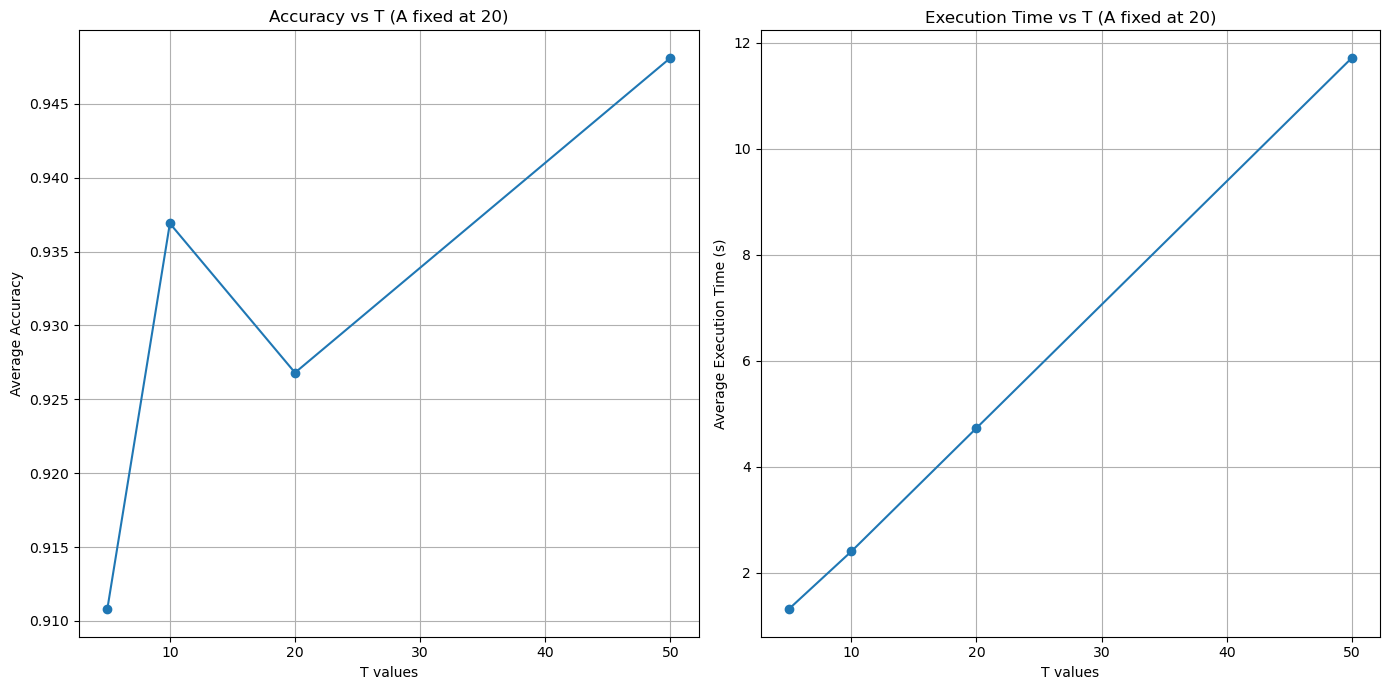

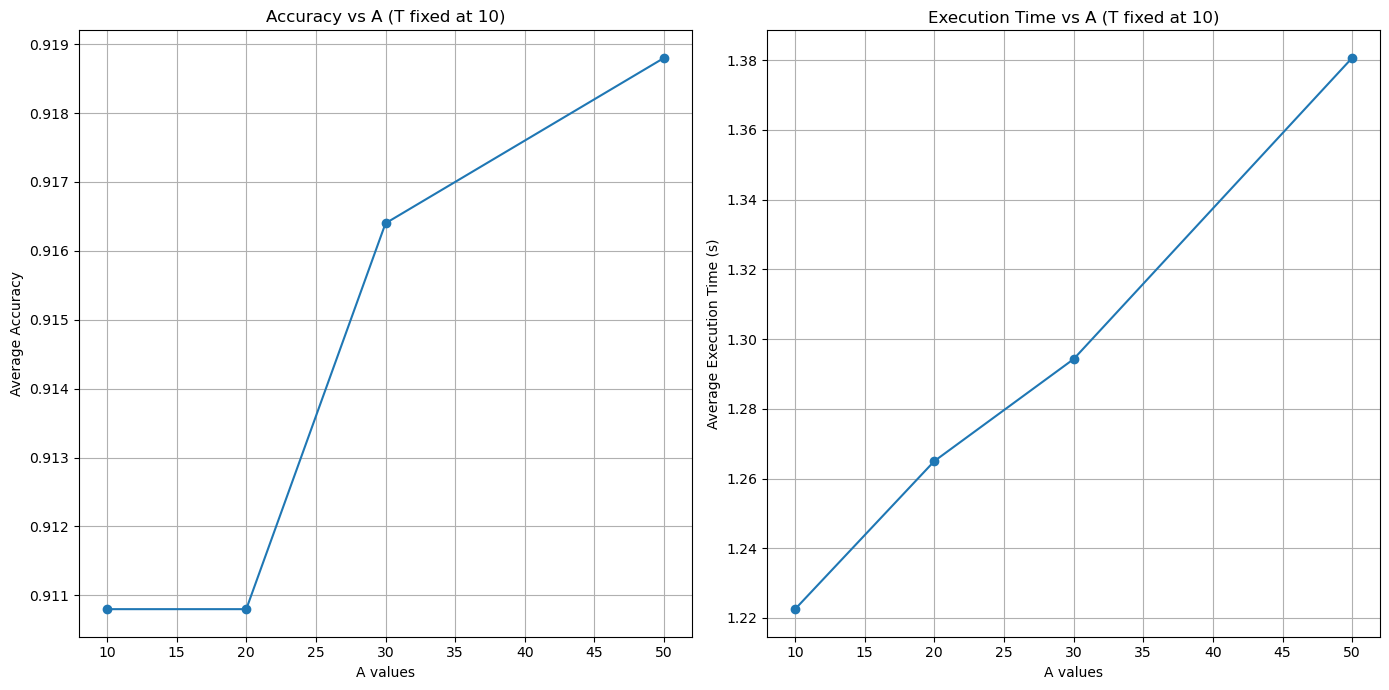

In [46]:
def graph_experimentation_for_task_2A(number_of_reps, digit):
    T_values = [5, 10, 20, 50]
    A_values = [10, 20, 30, 50]
    A_fixed = 20
    T_fixed = 5

    def run_experiment(T, A):
        acc = []
        exec_time = []
        for _ in range(number_of_reps):
            start_time = time.time()
            accuracy = run_adaboost_with_sklearn(digit, T=T, A=A, graph_param=True)
            end_time = time.time()
            acc.append(accuracy)
            exec_time.append(end_time - start_time)
        return np.mean(acc), np.mean(exec_time)

    # Accuracy vs T with A fixed
    accuracies_T = []
    exec_times_T = []
    for T in T_values:
        avg_acc, avg_exec_time = run_experiment(T, A_fixed)
        accuracies_T.append(avg_acc)
        exec_times_T.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(T_values, accuracies_T, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs T (A fixed at 20)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(T_values, exec_times_T, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs T (A fixed at 20)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Accuracy vs A with T fixed
    accuracies_A = []
    exec_times_A = []
    for A in A_values:
        avg_acc, avg_exec_time = run_experiment(T_fixed, A)
        accuracies_A.append(avg_acc)
        exec_times_A.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(A_values, accuracies_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs A (T fixed at 10)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(A_values, exec_times_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs A (T fixed at 10)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    number_of_reps = 3
    digit = 5  # You can choose any digit from 0 to 9
    graph_experimentation_for_task_2A(number_of_reps, digit)

Tarea 2B: clasificador débil árboles de decisión de 
profundidad mayor que 0

Solución Minimalista

In [48]:
import numpy as np #Importamos la librería numpy que sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # Importamos el dataset MNIST que contiene imágenes de dígitos escritos a mano
from sklearn.ensemble import AdaBoostClassifier # Importamos el clasificador AdaBoost de la librería scikit-learn que se utilizará como clasificador fuerte
from sklearn.tree import DecisionTreeClassifier # Importamos el clasificador DecisionTree de la librería scikit-learn que se utilizará como clasificador débil
from sklearn.metrics import accuracy_score # Importamos la función accuracy_score de la librería scikit-learn que se utilizará para calcular la precisión

def run_adaboost_with_sklearn(digit, T=50, A=20, max_depth = 1, graph_param = False): # Creamos la función run_adaboost_with_sklearn
    if graph_param == False:
        print(f"Running AdaBoost with sklearn for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data()  # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1)  # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1)  # Aplanamos los datos de prueba reduciendo la dimensión a 1D

    y_train_binary = np.where(y_train == digit, 1, -1)  # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias


    weak_clf = DecisionTreeClassifier(max_depth=max_depth, max_features=A, random_state=42) # Creamos un clasificador débil DecisionTree con profundidad 1


    adaboost = AdaBoostClassifier(estimator=weak_clf, n_estimators=T, algorithm='SAMME', random_state=42) # Creamos el clasificador AdaBoost con el clasificador débil y el número de iteraciones

    adaboost.fit(X_train, y_train_binary) # Ajustamos el clasificador AdaBoost
    
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones

    accuracy = accuracy_score(y_test_binary, y_pred) # Calculamos la precisión
    
    if graph_param == False:
        print(f"Accuracy for digit {digit} with sklearn: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits_sklearn(T=50, A=20, max_depth = 1): # Creamos la función run_adaboost_for_all_digits_sklearn
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_with_sklearn(digit, T, A, max_depth=max_depth) # Ejecutamos AdaBoost con sklearn
        accuracies[digit] = accuracy  # Guardamos la precisión
    return accuracies # Devolvemos las precisiones


In [ ]:
accuracies = run_adaboost_with_sklearn(5, T=50, A=20, max_depth=2)  # Ejecutamos AdaBoost con sklearn para todos los dígitos
print("Accuracies for one digits:", accuracies) # Imprimimos las precisiones

In [ ]:
accuracies = run_adaboost_for_all_digits_sklearn(T=5, A=20, max_depth=8)  # Ejecutamos AdaBoost con sklearn para todos los dígitos
print("Accuracies for all digits:", accuracies) # Imprimimos las precisiones

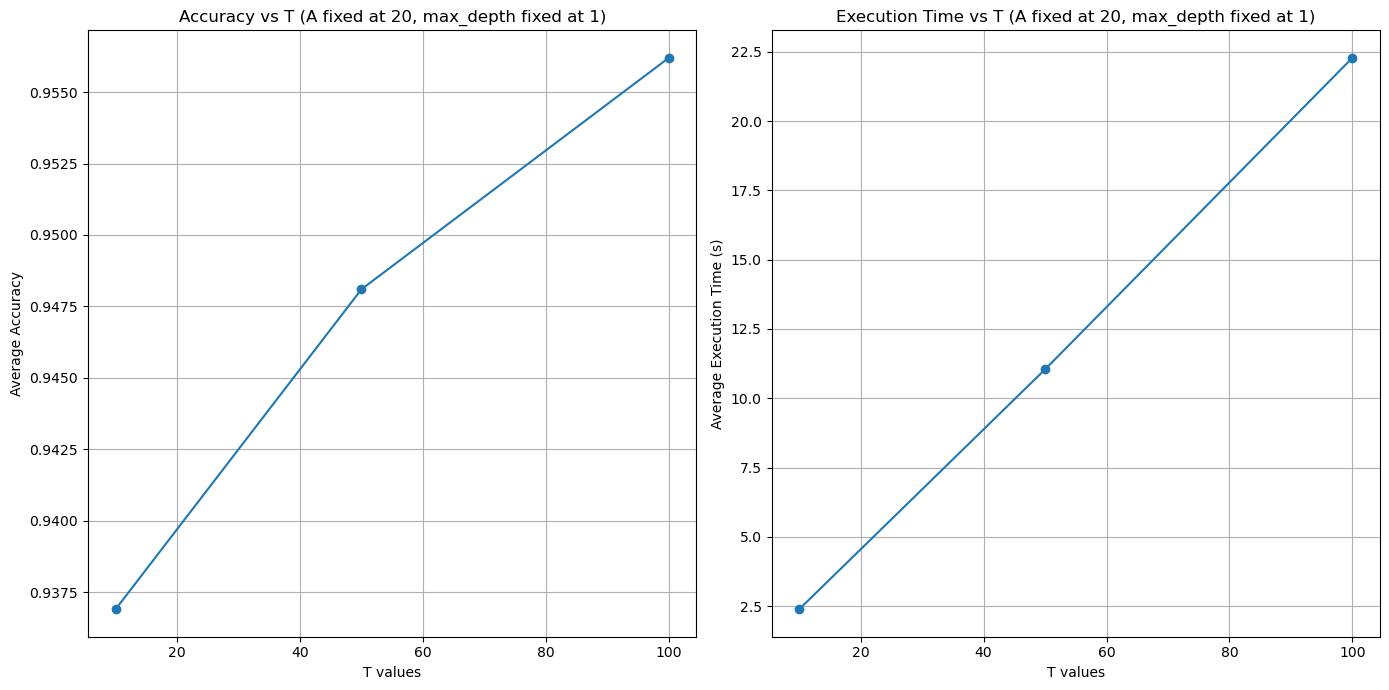

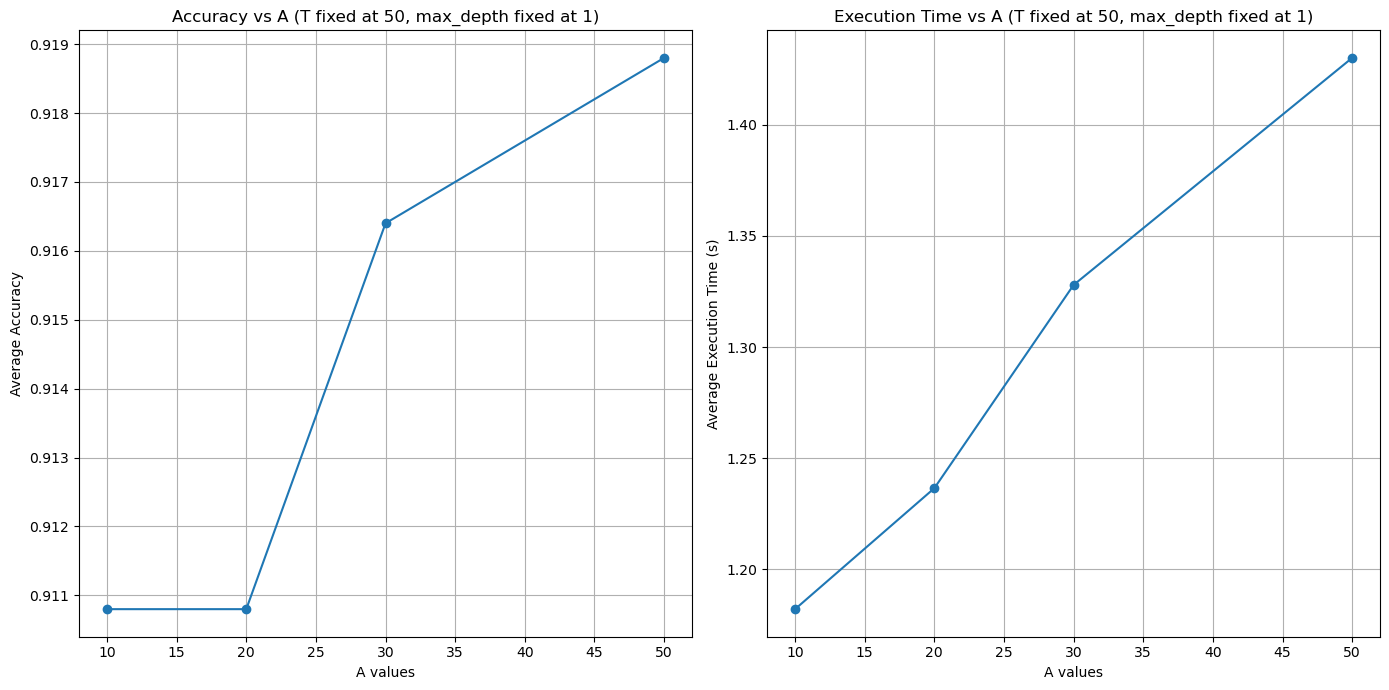

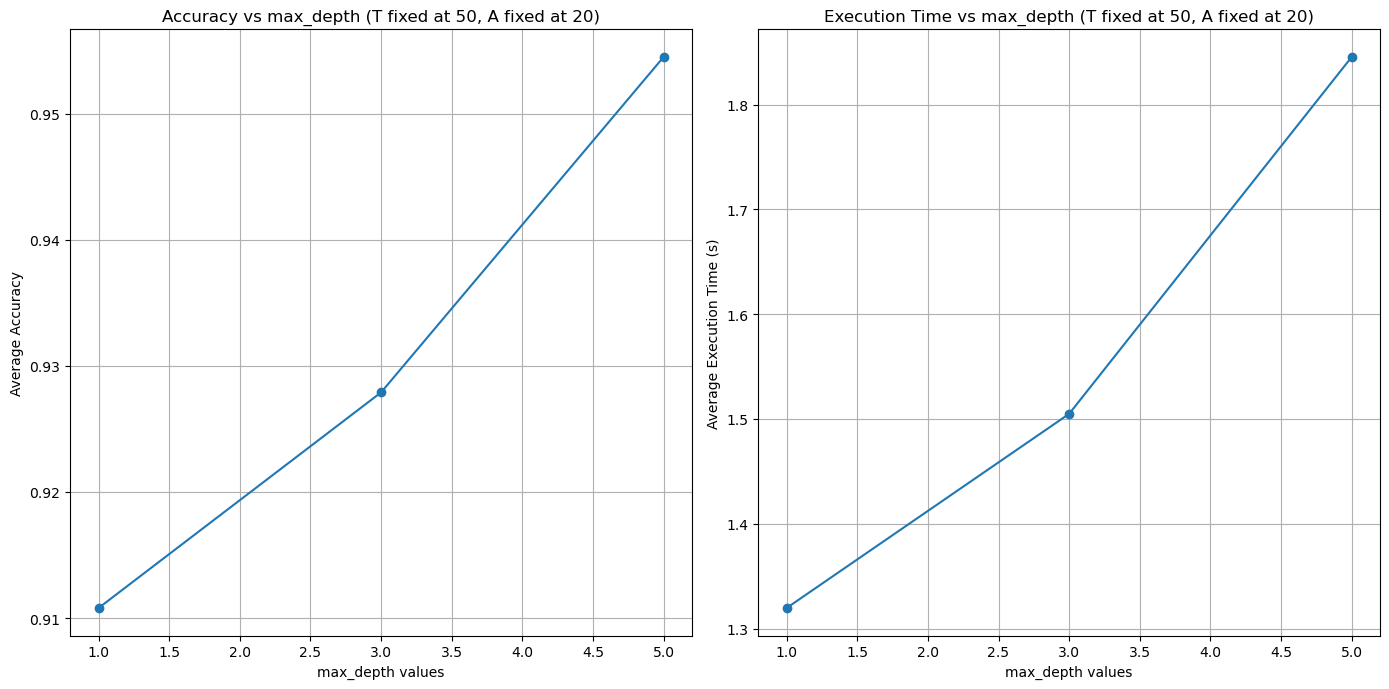

In [50]:
def graph_experimentation_for_task_2B(digit, number_of_reps):
    T_values = [10, 50, 100]
    A_values = [10, 20, 30, 50]
    max_depth_values = [1, 3, 5]
    T_fixed = 5
    A_fixed = 20
    max_depth_fixed = 1

    def run_experiment(T, A, max_depth):
        acc = []
        exec_time = []
        for _ in range(number_of_reps):
            start_time = time.time()
            accuracy = run_adaboost_with_sklearn(digit, T=T, A=A, max_depth=max_depth, graph_param=True)
            end_time = time.time()
            acc.append(accuracy)
            exec_time.append(end_time - start_time)
        return np.mean(acc), np.mean(exec_time)

    # Accuracy vs T with A and max_depth fixed
    accuracies_T = []
    exec_times_T = []
    for T in T_values:
        avg_acc, avg_exec_time = run_experiment(T, A_fixed, max_depth_fixed)
        accuracies_T.append(avg_acc)
        exec_times_T.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(T_values, accuracies_T, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs T (A fixed at 20, max_depth fixed at 1)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(T_values, exec_times_T, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs T (A fixed at 20, max_depth fixed at 1)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Accuracy vs A with T and max_depth fixed
    accuracies_A = []
    exec_times_A = []
    for A in A_values:
        avg_acc, avg_exec_time = run_experiment(T_fixed, A, max_depth_fixed)
        accuracies_A.append(avg_acc)
        exec_times_A.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(A_values, accuracies_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs A (T fixed at 50, max_depth fixed at 1)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(A_values, exec_times_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs A (T fixed at 50, max_depth fixed at 1)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Accuracy vs max_depth with T and A fixed
    accuracies_depth = []
    exec_times_depth = []
    for depth in max_depth_values:
        avg_acc, avg_exec_time = run_experiment(T_fixed, A_fixed, depth)
        accuracies_depth.append(avg_acc)
        exec_times_depth.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(max_depth_values, accuracies_depth, marker='o')
    plt.xlabel('max_depth values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs max_depth (T fixed at 50, A fixed at 20)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(max_depth_values, exec_times_depth, marker='o')
    plt.xlabel('max_depth values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs max_depth (T fixed at 50, A fixed at 20)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    number_of_reps = 3
    digit = 5  # Change this to the digit you want to analyze
    graph_experimentation_for_task_2B(digit, number_of_reps)

Tarea 2C:  Utilización de la librería Keras para implementar un Multi-Layer 
Perceptron.

Version 1 (less fast)

In [ ]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

def load_and_preprocess_data():
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    Y_train = to_categorical(Y_train, 10)
    Y_test = to_categorical(Y_test, 10)
    
    return X_train, Y_train, X_test, Y_test

def create_mlp_model(input_shape, learning_rate, num_layers):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    
    for _ in range(num_layers):
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
    
    model.add(Dense(10, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])
    
    return model

def main():
    X_train, Y_train, X_test, Y_test = load_and_preprocess_data()
    
    input_shape = X_train.shape[1:]
    learning_rate = 0.001
    num_layers = 2  # Specify the number of layers here
    
    model = create_mlp_model(input_shape, learning_rate, num_layers)
    
    batch_size = 128  # Updated to match the image's batch size
    epochs = 10
    validation_split = 0.1
    
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=True, validation_data=(X_test, Y_test))
    
    score = model.evaluate(X_test, Y_test, verbose=False)
    print(f'Test loss: {score[0]:.4f}')
    print(f'Test accuracy: {score[1]: .4f}')
    

In [ ]:
main()

In [ ]:
def graph_experimentation_for_task_2D(number_of_reps):
    learning_rate_values = [0.001, 0.01, 0.1]
    num_layers_values = [1, 2, 3]
    batch_size_values = [64, 128, 256]
    
    fixed_learning_rate = 0.001
    fixed_num_layers = 2
    fixed_batch_size = 128
    epochs = 10
    validation_split = 0.1

    def run_experiment(learning_rate, num_layers, batch_size):
        X_train, Y_train, X_test, Y_test = load_and_preprocess_data()
        input_shape = X_train.shape[1:]

        acc = []
        exec_time = []
        for _ in range(number_of_reps):
            start_time = time.time()
            model = create_mlp_model(input_shape, learning_rate, num_layers)
            model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=False)
            score = model.evaluate(X_test, Y_test, verbose=False)
            end_time = time.time()
            acc.append(score[1])
            exec_time.append(end_time - start_time)
        return np.mean(acc), np.mean(exec_time)

    # Accuracy vs Learning Rate with fixed number of layers and batch size
    accuracies_lr = []
    exec_times_lr = []
    for lr in learning_rate_values:
        avg_acc, avg_exec_time = run_experiment(lr, fixed_num_layers, fixed_batch_size)
        accuracies_lr.append(avg_acc)
        exec_times_lr.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(learning_rate_values, accuracies_lr, marker='o')
    plt.xlabel('Learning Rate values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs Learning Rate (num_layers fixed at 2, batch_size fixed at 128)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(learning_rate_values, exec_times_lr, marker='o')
    plt.xlabel('Learning Rate values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs Learning Rate (num_layers fixed at 2, batch_size fixed at 128)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Accuracy vs Number of Layers with fixed learning rate and batch size
    accuracies_layers = []
    exec_times_layers = []
    for num_layers in num_layers_values:
        avg_acc, avg_exec_time = run_experiment(fixed_learning_rate, num_layers, fixed_batch_size)
        accuracies_layers.append(avg_acc)
        exec_times_layers.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(num_layers_values, accuracies_layers, marker='o')
    plt.xlabel('Number of Layers')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs Number of Layers (learning_rate fixed at 0.001, batch_size fixed at 128)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(num_layers_values, exec_times_layers, marker='o')
    plt.xlabel('Number of Layers')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs Number of Layers (learning_rate fixed at 0.001, batch_size fixed at 128)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Accuracy vs Batch Size with fixed learning rate and number of layers
    accuracies_batch_size = []
    exec_times_batch_size = []
    for batch_size in batch_size_values:
        avg_acc, avg_exec_time = run_experiment(fixed_learning_rate, fixed_num_layers, batch_size)
        accuracies_batch_size.append(avg_acc)
        exec_times_batch_size.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(batch_size_values, accuracies_batch_size, marker='o')
    plt.xlabel('Batch Size')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs Batch Size (learning_rate fixed at 0.001, num_layers fixed at 2)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(batch_size_values, exec_times_batch_size, marker='o')
    plt.xlabel('Batch Size')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs Batch Size (learning_rate fixed at 0.001, num_layers fixed at 2)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    number_of_reps = 3
    graph_experimentation_for_task_2D(number_of_reps)

Tarea 2D:  Modelado de un clasificador mediante CNN para MNIST 
con Keras

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import to_categorical

def load_and_preprocess_data():
    # Load the MNIST dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Reshape the data to fit the model
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
    
    # Normalize the data to the range [0, 1]
    x_train /= 255
    x_test /= 255
    
    # One-hot encode the labels
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    
    return (x_train, y_train), (x_test, y_test)

def build_cnn_model(num_conv_layers=2, num_dense_layers=1, conv_filters=[32, 64], dense_units=[128], input_shape=(28, 28, 1)):
    model = Sequential()
    
    # Add convolutional layers
    for i in range(num_conv_layers):
        if i == 0:
            # First layer needs to specify the input shape
            model.add(Conv2D(conv_filters[i], kernel_size=(3, 3), input_shape=input_shape))
        else:
            model.add(Conv2D(conv_filters[i], kernel_size=(3, 3)))
        
        # Add batch normalization
        model.add(BatchNormalization())
        # Add a LeakyReLU activation function with negative_slope
        model.add(LeakyReLU(negative_slope=0.1))
        # Add a max pooling layer
        model.add(MaxPooling2D(pool_size=(2, 2)))
        # Add a dropout layer to prevent overfitting
        model.add(Dropout(0.25))
    
    # Flatten the layer
    model.add(Flatten())
    
    # Add dense layers
    for units in dense_units:
        model.add(Dense(units))
        model.add(BatchNormalization())
        model.add(LeakyReLU(negative_slope=0.1))
        model.add(Dropout(0.5))
    
    # Add the output layer with 10 units and softmax activation function
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    # Train the model
    model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test, y_test))
    
    # Evaluate the model
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {:.4f}'.format(score[0]))
    print('Test accuracy: {:.4f}'.format(score[1]))

if __name__ == "__main__":
    # Load and preprocess the data
    (x_train, y_train), (x_test, y_test) = load_and_preprocess_data()
    
    # Build the CNN model
    model = build_cnn_model(num_conv_layers=2, num_dense_layers=1, conv_filters=[32, 64], dense_units=[128])
    
    # Train and evaluate the model
    train_and_evaluate_model(model, x_train, y_train, x_test, y_test)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.8324 - loss: 0.5472 - val_accuracy: 0.5864 - val_loss: 1.3409
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9659 - loss: 0.1171 - val_accuracy: 0.9799 - val_loss: 0.0595
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9735 - loss: 0.0866 - val_accuracy: 0.9881 - val_loss: 0.0352
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9790 - loss: 0.0731 - val_accuracy: 0.9910 - val_loss: 0.0288
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9825 - loss: 0.0603 - val_accuracy: 0.9915 - val_loss: 0.0265
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9826 - loss: 0.0575 - val_accuracy: 0.9903 - val_loss: 0.0278
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9844 - loss: 0.0524 - val_accuracy: 0.9912 - val_loss: 0.0242
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9852 - loss: 0.0478 - 